### Aspirante: Fernando Andrés Roa Martín
### Objetivo: Modelo predictivo
### Dataset: bank_transactions
### Fecha: 2024/09/03

#### Modelo para predicción de abonos, gastos y provisión de recursos para clientes
* Objetivo y Tipo de Modelo. Predecir el flujo de caja con modelos de series de tiempo. Se utilizará el modelo prophet de Meta para predecir el total de abonos, retiros y posible dinero a aprovisionar, el cual es el resultado de restar los abonos menos los retiros a nivel semanal.

In [1]:
# Cargue de librerías

# Importar librerías para la manipulación y análisis de datos
import pandas as pd  
import numpy as np

# Importar la clase Prophet para el modelo de predicción
from prophet import Prophet

# Importar librería para visualización
import matplotlib.pyplot as plt

# Métricas de evaluación de modelos de clasificación
from sklearn.metrics import mean_absolute_percentage_error, r2_score

c:\Users\57313\Documents\10. MeLi\scripts\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Carga del dataset bank_transactions

df = pd.read_parquet('./inputs/bank_transactions.parquet')

In [3]:
# Visualizar los primeros registros del dataset

df.head(5)

,account_id,date,transaction_details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,category,city,device
0,'409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,Transfer,New York,Tablet
1,'409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,Transfer,Phoenix,Mobile
2,'409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,Investment,Dallas,Tablet
3,'409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,Transfer,San Jose,Desktop
4,'409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,Investment,Philadelphia,Desktop


In [4]:
# Transformación de las variables 'withdrawal_amt' y 'deposit_amt' aplicando logaritmo natural

df['log_deposit_amt'] = np.log1p(df['deposit_amt'])  # log(1 + x), maneja valores en cero
df['log_withdrawal_amt'] = np.log1p(df['withdrawal_amt'])

# Asegurar que el tipo de dato de la columna 'date' sea datetime

df['date'] = pd.to_datetime(df['date'])

In [5]:
# Crear un dataframe con las columnas 'date' y 'log_deposit_amt' para modelar
df_deposit = df.loc[:, ['date', 'log_deposit_amt']]

# Establecer la columna 'date' como índice del DataFrame
df_deposit.set_index('date', inplace=True)

# Realizar un resample del dataframe con una periodicidad semanal
df_deposit_weekly = df_deposit.resample('W').sum()[1:-1] # Se elimina la primera y última semana

# Visualizar los primeros registros de df_deposit_weekly
df_deposit_weekly.head(3)

,log_deposit_amt
date,
2015-01-11,372.441099
2015-01-18,482.698687
2015-01-25,524.589725


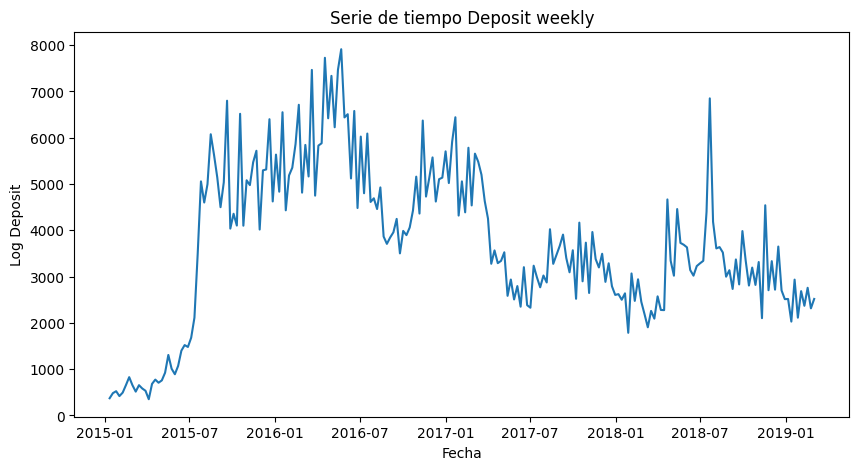

In [6]:
# Gráfico de la variable log_deposit_amt semanal en función del tiempo

plt.figure(figsize=(10,5))
plt.plot(df_deposit_weekly)
plt.xlabel('Fecha')
plt.ylabel('Log Deposit')
plt.title('Serie de tiempo Deposit weekly')
plt.show()

In [7]:
# Crear un dataframe con las columnas 'date' y 'log_withdrawal_amt' para modelar
df_withdrawal = df.loc[:, ['date', 'log_withdrawal_amt']]

# Establecer la columna 'date' como índice del DataFrame
df_withdrawal.set_index('date', inplace=True)

# Realizar un resample del dataframe con una periodicidad semanal
df_withdrawal_weekly = df_withdrawal.resample('W').sum()[1:-1] # Se elimina la primera y última semana

# Visualizar los primeros registros de df_deposit_weekly
df_withdrawal_weekly.head(3)

,log_withdrawal_amt
date,
2015-01-11,114.910907
2015-01-18,116.308700
2015-01-25,113.915836


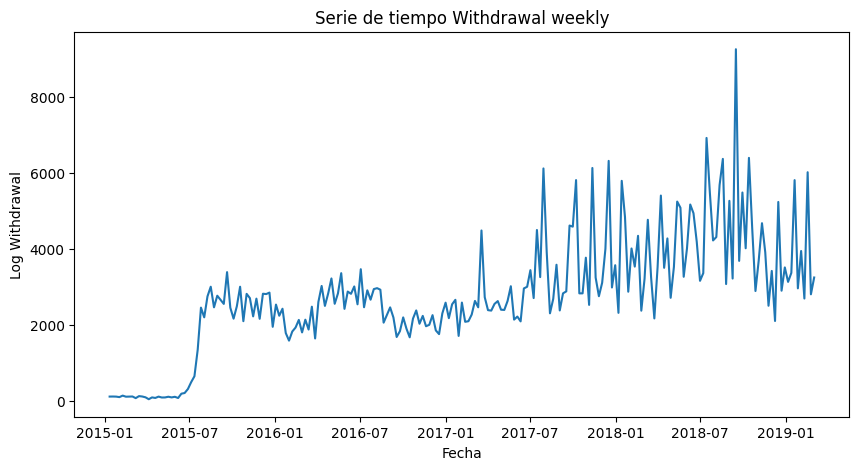

In [8]:
# Gráfico de la variable log_withdrawal_amt semanal en función del tiempo

plt.figure(figsize=(10,5))
plt.plot(df_withdrawal_weekly)
plt.xlabel('Fecha')
plt.ylabel('Log Withdrawal')
plt.title('Serie de tiempo Withdrawal weekly')
plt.show()

##### Modelado - Log Deposit

In [9]:
# Resetear el índice del dataframe
df_deposit_weekly.reset_index(inplace=True)

# Renombrar las columnas
df_deposit_weekly.rename(columns={'date':'ds', 'log_deposit_amt': 'y'}, inplace=True)

In [10]:
# Separar la data en train y test
fecha_minima = pd.to_datetime('2016-01-01')
fecha_referencia = pd.to_datetime('2018-07-01')
df_deposit_weekly_train = df_deposit_weekly.loc[(df_deposit_weekly['ds']>=fecha_minima) &\
    (df_deposit_weekly['ds']<fecha_referencia)]
df_deposit_weekly_test = df_deposit_weekly.loc[df_deposit_weekly['ds']>=fecha_referencia]

In [11]:
# Instanciar el modelo
model_deposit = Prophet()

# Entrenar el modelo
model_deposit.fit(df_deposit_weekly_train)

22:36:13 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Realizar predicciones de deposit sobre el dataset de test
df_deposit_weekly_predict = model_deposit.predict(df_deposit_weekly_test)

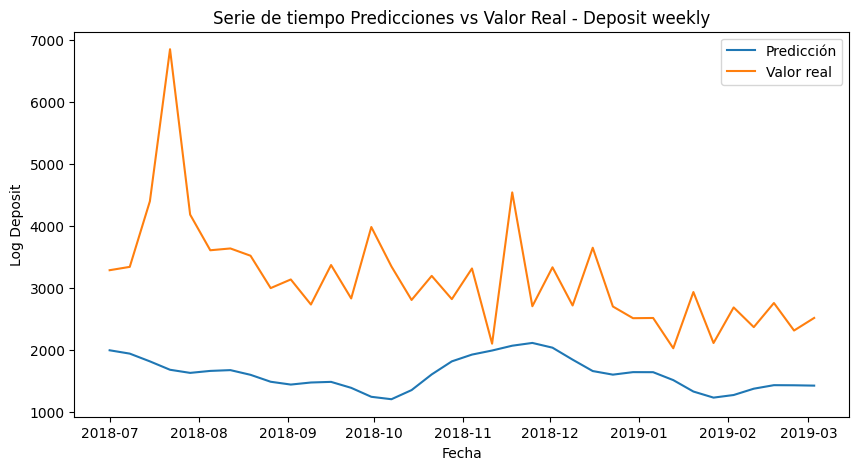

In [13]:
# Gráfico de la predicciones de log_deposit_amt semanal

plt.figure(figsize=(10,5))
plt.plot(df_deposit_weekly_predict['ds'], df_deposit_weekly_predict['yhat'], label = 'Predicción')
plt.plot(df_deposit_weekly_predict['ds'], df_deposit_weekly_test['y'], label = 'Valor real')
plt.xlabel('Fecha')
plt.ylabel('Log Deposit')
plt.title('Serie de tiempo Predicciones vs Valor Real - Deposit weekly')
plt.legend()
plt.show()

##### Cálculo de error - MAPE

In [14]:
mape = round(mean_absolute_percentage_error(df_deposit_weekly_test['y'], df_deposit_weekly_predict['yhat'])*100, 2)
print(f'El error absoluto medio porcentual es: {mape}%')

El error absoluto medio porcentual es: 46.39%


##### Modelado - Log Withdrawal

In [15]:
# Resetear el índice del dataframe
df_withdrawal_weekly.reset_index(inplace=True)

# Renombrar las columnas
df_withdrawal_weekly.rename(columns={'date':'ds', 'log_withdrawal_amt': 'y'}, inplace=True)

In [16]:
# Separar la data en train y test
fecha_minima = pd.to_datetime('2016-01-01')
fecha_referencia = pd.to_datetime('2018-07-01')
df_withdrawal_weekly_train = df_withdrawal_weekly.loc[(df_withdrawal_weekly['ds']>=fecha_minima) &\
    (df_withdrawal_weekly['ds']<fecha_referencia)]
df_withdrawal_weekly_test = df_withdrawal_weekly.loc[df_withdrawal_weekly['ds']>=fecha_referencia]

In [17]:
# Instanciar el modelo
model_withdrawal = Prophet()

# Entrenar el modelo
model_withdrawal.fit(df_withdrawal_weekly_train)

22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Realizar predicciones de deposit sobre el dataset de test
df_withdrawal_weekly_predict = model_withdrawal.predict(df_withdrawal_weekly_test)

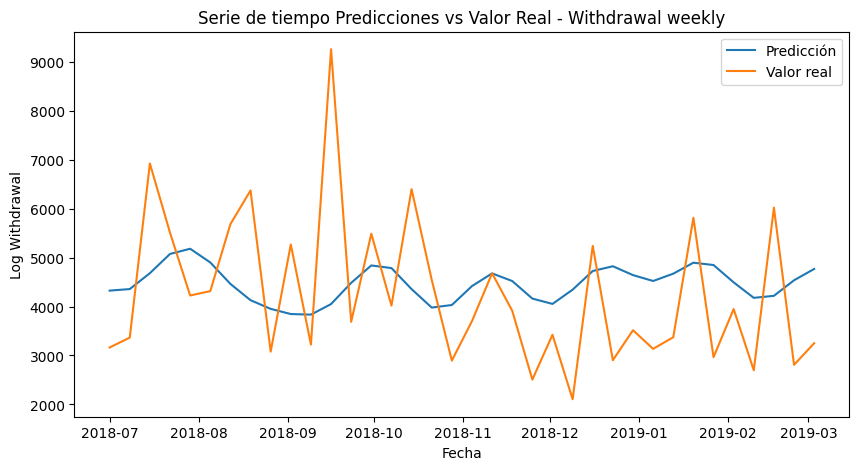

In [19]:
# Gráfico de la predicciones de log_withdrawal_amt semanal

plt.figure(figsize=(10,5))
plt.plot(df_withdrawal_weekly_predict['ds'], df_withdrawal_weekly_predict['yhat'], label = 'Predicción')
plt.plot(df_withdrawal_weekly_predict['ds'], df_withdrawal_weekly_test['y'], label = 'Valor real')
plt.xlabel('Fecha')
plt.ylabel('Log Withdrawal')
plt.title('Serie de tiempo Predicciones vs Valor Real - Withdrawal weekly')
plt.legend()
plt.show()

##### Cálculo de error - MAPE

In [20]:
mape = round(mean_absolute_percentage_error(df_withdrawal_weekly_test['y'], df_withdrawal_weekly_predict['yhat'])*100, 2)
print(f'El error absoluto medio porcentual es: {mape}%')

El error absoluto medio porcentual es: 32.48%


#### Cálculo del aprovisionamiento

In [40]:
# Crear un dataframe con las predicciones de log_deposit y log_withdrawal

df_provision = df_deposit_weekly_predict.loc[:, ['ds', 'yhat']].merge(df_withdrawal_weekly_predict.loc[:, ['ds', 'yhat']],\
    how='left', on='ds')

# Renombrar las variables
df_provision.rename(columns={'yhat_x':'pred_log_deposit', 'yhat_y':'pred_log_withdrawal'}, inplace=True)

# Calcular la columna de log_provisiones
df_provision['log_provision'] = df_provision['pred_log_withdrawal'] - df_provision['pred_log_deposit']

In [42]:
# Visualización de primeros registros
df_provision.head(3)

,ds,pred_log_deposit,pred_log_withdrawal,log_provision
0,2018-07-01,1995.662949,4326.603613,2330.940664
1,2018-07-08,1941.840373,4358.372805,2416.532433
2,2018-07-15,1816.829689,4683.410347,2866.580658


#### Conclusiones del Modelo

1. Se desarrollaron dos modelos de series de tiempo:
   - Uno para calcular la suma de abonos semanales totales a las cuentas de diferentes usuarios.
   - Otro para calcular la suma de retiros semanales totales de las cuentas de diferentes usuarios.
2. A partir de las predicciones de abonos y retiros semanales, se calculó la provisión como la diferencia entre los retiros y los abonos. Un resultado positivo indica la necesidad de aprovisionar dinero para garantizar la disponibilidad para los clientes.
3. El Error Absoluto Medio Porcentual (MAPE) de las predicciones fue:
   - Abonos: 46.39%, lo cual indica una precisión baja en la predicción de abonos semanales.
   - Retiros: 32.48%, lo cual indica una precisión baja en la predicción de retiros.
4. Limitaciones del Dataset:
   - La data utilizada contiene transacciones de solo 10 cuentas, lo cual limita la representatividad de la misma y el rendimiento del modelo puede afectarse.
   - Dos cuentas dominan el dataset con una transaccionalidad cercana al 70% aprox., lo que puede haber sesgado las predicciones y afectado la distribución de los datos.
5. Recomendaciones para Mejorar el Modelo:
   - Ampliar la Muestra de Cuentas: Incorporar más cuentas en el dataset podría reducir el error de las predicciones al aumentar la diversidad y representatividad de los datos.
   - Incluir datos de fechas relevantes: Festivos, fines de semana o fechas de pagos de salario o primas que pueden afectar los patrones de abonos y retiros. Incluir estas variables como features adicionales podría mejorar la precisión del modelo.
   - Datos Adicionales de los Usuarios: Información sobre los usuarios, como su perfil financiero, ingresos, gastos fijos.
   - Revisión de la Calidad de los Datos: Verificar la distribución y calidad de los datos, especialmente en las cuentas predominantes, para asegurar que la transaccionalidad refleje adecuadamente la realidad.
6. Conclusión General:
   - El modelo proporciona una base inicial para predecir abonos y retiros semanales y calcular la provisión necesaria. Sin embargo, existen áreas de mejora significativas, especialmente en la ampliación del dataset y la inclusión de variables adicionales, que pueden potencialmente reducir los errores de predicción y aumentar la confiabilidad de los resultados.
